# Uma introdução à predição em séries temporais 

***

Adelson Dias de Araujo jr 
- Email : adelsondias@live.com
- Github: [@adaj](adaj.github.io)
- LinedkIn: [@adelson-araujo-junior](https://www.linkedin.com/in/adelson-araujo-junior/)


## Sumário


1. Contextualização<br>
2. Análise exploratória<br>
    2.1. Agregação no tempo<br>
    2.2. Missing data<br>
    2.3. Estacionariedade<br>
    2.4. Decomposição - Tendência e Sazonalidade<br>
    2.5. Análise de autocorrelação<br>
3. Extração de descritores<br>
    3.1. Regressão e predição<br>
    3.2. Descritores autorregressivos<br>
    3.3. Descritores exógenos<br>
    3.4. Seleção de descritores<br>
4. Análise preditiva<br>
    4.1. Aprendizado de máquina<br>
    4.2. Performance dos modelos<br>
    4.3. Engenharia de descritores<br>
5. Conclusão<br>

### 0. Tecnologias tradicionais para análise de séries temporais em Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

## 1. Contextualização

***


Aplicações de séries temporais estão nas diversas ciências, como:

- Demografia
- Geoestatística
- Econometria
- Astrofísica
- Epidemiologia
- Bioinformática
- Criminologia
- etc

Um problema de análise de séries temporais pode se apresentar de diversas formas, principalmente sob a forma de:

#### a) Valores contínuos em tempo discreto (exemplo abaixo)

In [2]:
trends = pd.read_csv('data/trends.csv',header=1, index_col=0)
trends.index = pd.to_datetime(trends.index)
trends.head()

,time series: (Todo o mundo),data science: (Todo o mundo),big data: (Todo o mundo)
Mês,,,
2004-01-01,38,8,4
2004-02-01,43,9,4
2004-03-01,41,7,5
2004-04-01,45,8,5
2004-05-01,40,7,3


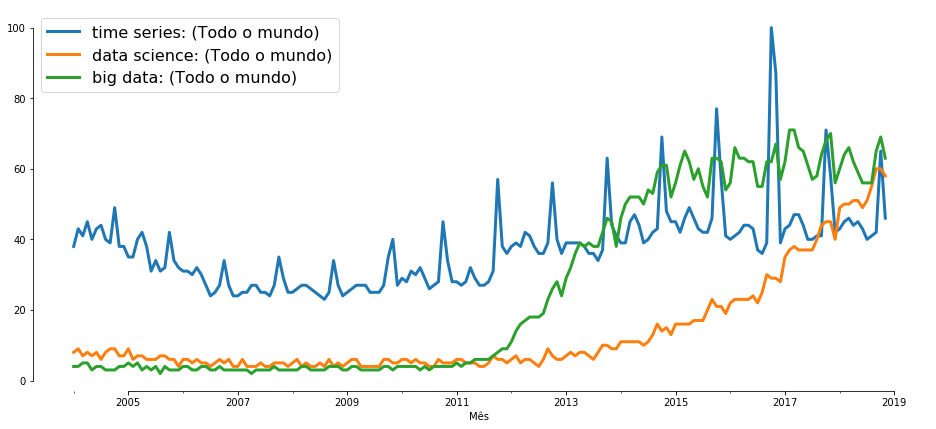

In [3]:
fig, ax = plt.subplots(figsize=(16,7))
trends.plot(ax=ax, linewidth=3)
ax.legend(fontsize=16, loc=2)
sns.despine(trim=True)

#### b) Eventos discretos em tempo contínuo/discreto (exemplo abaixo)

In [4]:
crimes = pd.read_csv('data/newcastle_crimes.csv', index_col=0)
crimes['Month'] = pd.to_datetime(crimes['Month'])
crimes.head()

,Month,Latitude,Longitude,Crime type
2436,2017-05-01,55.013032,-1.668240,Anti-social behaviour
2437,2017-05-01,55.010479,-1.678049,Criminal damage and arson
2438,2017-05-01,55.010743,-1.669463,Criminal damage and arson
2439,2017-05-01,55.010712,-1.667884,Criminal damage and arson
2440,2017-05-01,55.012377,-1.675595,Other theft


In [5]:
burglary_ts = crimes.loc[crimes['Crime type']=='Burglary'].groupby(['Month']).size()
burglary_ts.name = 'Burglary'
drugs_ts = crimes.loc[crimes['Crime type']=='Drugs'].groupby(['Month']).size()
drugs_ts.name = 'Drugs'

burglary_ts.head()

Month
2015-05-01    170
2015-06-01    211
2015-07-01    177
2015-08-01    162
2015-09-01    180
Name: Burglary, dtype: int64

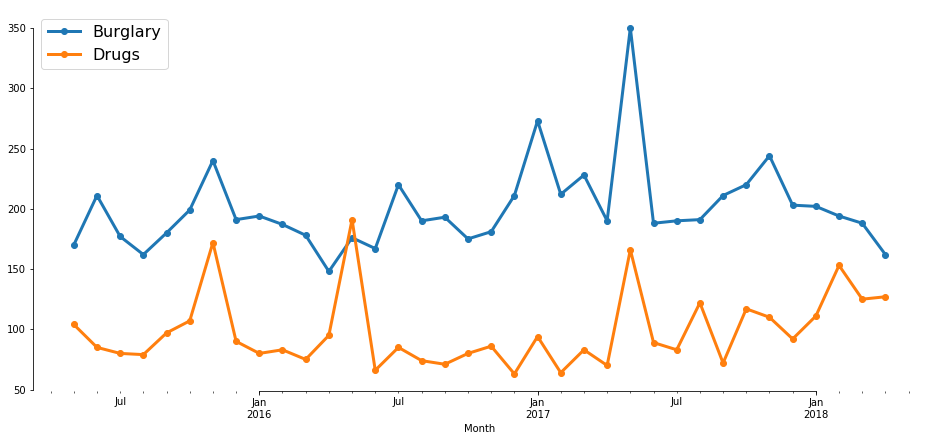

In [6]:
fig, ax = plt.subplots(figsize=(16,7))
burglary_ts.plot(ax=ax, linewidth=3, marker='o')
drugs_ts.plot(ax=ax, linewidth=3, marker='o')
ax.legend(fontsize=16, loc=2)
sns.despine(trim=True)

## 2. Análise exploratória

***


### 2.1. Agregação no tempo

Dois importantes aspectos ligados a dimensão temporal trazem as primeiras subjetividade às análises em séries temporais, e podem ser determinados pelas necessidades da aplicação. São eles (1) a **frequência de amostragem** e (2) o **método de agregação**.

Considere a série temporal de crimes `burglary_ts`, que foi coletada já com amostras de frequência mensal. 

Se a cidade fosse analisar uma medida para a criminalidade considerando a quantidade de crimes por ano, uma agregação deveria ser feita. Há ainda a opção de se agregar considerando medidas de posição como a média, mediana, máximo, mínimo ou por quantidade de amostras.

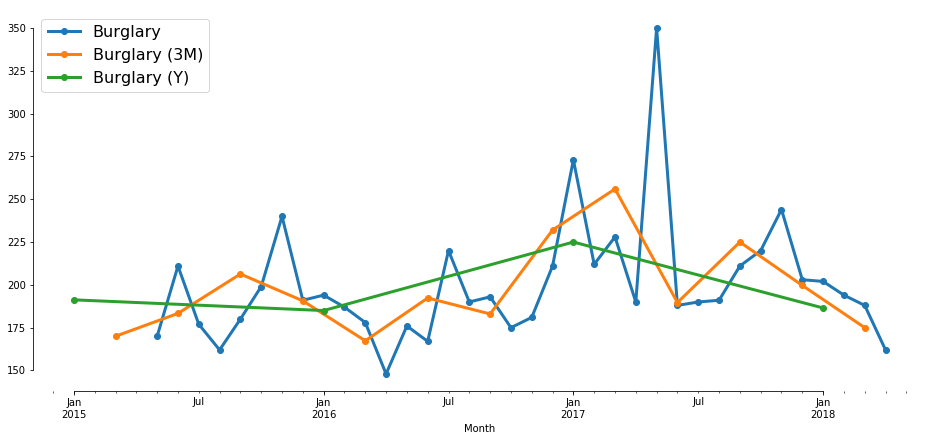

In [7]:
r3m = burglary_ts.resample('3M').mean()
r3m.name = 'Burglary (3M)'
r1y = burglary_ts.resample('Y').mean()
r1y.name = 'Burglary (Y)'

fig, ax = plt.subplots(figsize=(16,7))
burglary_ts.plot(ax=ax, linewidth=3, marker='o')
r3m.plot(ax=ax, linewidth=3, marker='o')
r1y.plot(ax=ax, linewidth=3, marker='o')
ax.legend(fontsize=16, loc=2)
sns.despine(trim=True)

### 2.2. Missing data

<br>
* Um enorme problema para análise de séries temporais, principalmente no que se diz respeito a predição, é a falta de dados entre instantes de tempo, ou *missing data*. Isso por que, como vamos ver, estratégias de predição se baseiam em instantes anteriores para prever um próximo.


* Dentre as maneiras mais simples de se tratar esse problema é imputar medidas de posição como média ou mediana nos espaços faltantes. Há estratégias mais elaboradas, tanto na literatura tradicional de séries temporais como em aprendizado de máquina, como a própria regressão ou técnicas de aprendizagem semi-supervisionada.

* Como cada caso é um caso, dependendo das condições o analista pode ter de "dropar" uma parte da série se quiser fazer estimativas mais razoáveis.

### 2.3. Estacionariedade

<br>
* Uma série, ou um sinal qualquer, é dita *estacionária* se as suas medidas de momento (principalmente média e variância, que são os momentos de primeira e segunda ordem, respectivamente) são constantes, ou oscilam ao redor de um valor constante.


* Existem métodos estatísticos para medir estacionariedade, como o [teste de Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test), que testa a hipótese nula de que as amostras apresentam uma raiz unitária, ou em outras palavras, que não é estacionária. 

Verifiquemos se as séries apresentadas anteriormente são estacionárias, analisando o p-valor do teste. Caso o p-valor seja menor que um dado $\alpha$ (vamos considerar 5%, ou 0.05), rejeita-se a hipótese nula e podemos considerar a série estacionária.

In [8]:
print('(trends) time-series -', adfuller(trends['time series: (Todo o mundo)'])[1] < 0.05)
print('(trends) data-science -', adfuller(trends['data science: (Todo o mundo)'])[1] < 0.05)
print('(trends) big-data -', adfuller(trends['big data: (Todo o mundo)'])[1] < 0.05)
print('(crimes) burglary -', adfuller(burglary_ts)[1] < 0.05)
print('(crimes) drugs -', adfuller(drugs_ts)[1] < 0.05)

(trends) time-series - False
(trends) data-science - False
(trends) big-data - False
(crimes) burglary - True
(crimes) drugs - True


* Saber se uma série é estacionária pode servir para a seleção de um modelo de séries temporais mais adequado. Séries estacionárias se comportam melhor em modelos lineares. 


* Uma série $Y$ pode ser "estacionarizada" através da aplicação de um operador de diferenciação, isto é, a próxima amostra é a subtração entre a anterior e a atual. Matematicamente: 

<h2>$Y_d(t) = Y(t) - Y(t-1)$</h2><br>

Vamos estacionarizar a série do trends sobre time-series e verificar seu p-valor.

Novo p-valor: 0.010568727308566802


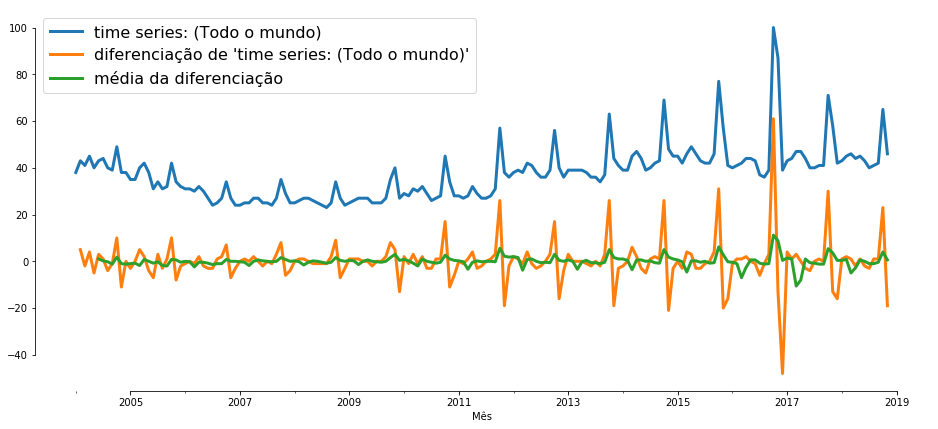

In [9]:
diff_ts = np.diff(trends['time series: (Todo o mundo)'].values)
diff_ts = pd.Series(diff_ts, index=trends['time series: (Todo o mundo)'].index[1:])
print('Novo p-valor:',adfuller(diff_ts)[1])

fig, ax = plt.subplots(figsize=(16,7))
trends['time series: (Todo o mundo)'].plot(ax=ax, linewidth=3)
diff_ts.plot(ax=ax, linewidth=3, label='diferenciação de \'time series: (Todo o mundo)\'')
diff_ts.rolling(window=5).mean().plot(ax=ax, linewidth=3, label='média da diferenciação')
ax.legend(fontsize=16, loc=2)
sns.despine(trim=True)

### 2.4. Decomposição - Tendência e Sazonalidade


* Os eventos representados por séries temporais muitas vezes estão associados a comportamento gerais que flutuam de maneira macro ao longo do tempo. Chamamos isso de **tendência**.


* Sob outra perspectiva, também podem ser observados padrões de repetição em intervalos de tempo, indicando um comportamento periódico que pode se repetir dado uma frequência, como semanal, mensal etc. Essa periodicidade pode ser camada de **sazonalidade**.

* A literatura de séries temporais se preocupou desde muito tempo em desenvolver métodos de decomposição de séries em tendências, através do cálculo de médias móveis, e sazonalidades, através da aplicação de filtros no domínio da frequência.

Em python, essa decomposição pode ser feita utilizando a implementação do `statsmodels`. Verifiquemos esses comportamentos na mesma série tratada anteriormente.

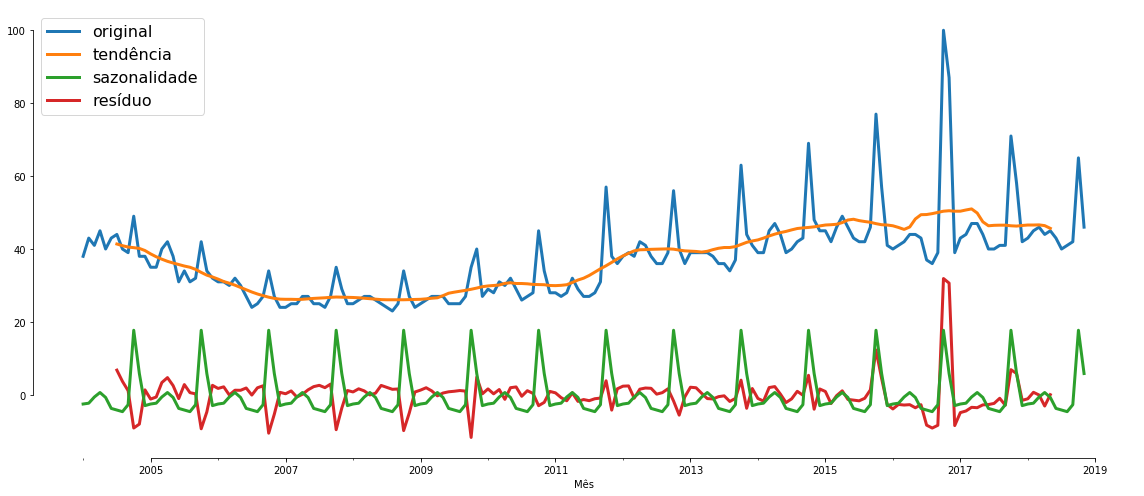

In [10]:
d = seasonal_decompose(trends['time series: (Todo o mundo)'])

fig, ax = plt.subplots(figsize=(16,7))
trends['time series: (Todo o mundo)'].plot(ax=ax, linewidth=3, label='original')
d.trend.plot(ax=ax, linewidth=3, label='tendência')
d.seasonal.plot(ax=ax, linewidth=3, label='sazonalidade')
d.resid.plot(ax=ax, linewidth=3, label='resíduo',zorder=0)

plt.legend(loc=2, fontsize=16)
sns.despine(trim=True)
plt.tight_layout()

### 2.5. Análise de autocorrelação

* Continuando com a análise exploratória, é comum investigar e quantificar o grau de correlação que a série possui consigo mesmo. As observações anteriores, frequentemente chamadas de ***lags***, são importantes quando a tarefa a ser realizada é a predição. Especificamente através da função de autocorrelação (ACF), é possível verificar a correlação entre as amostras e os seus *lags*.

Analisemos a ACF da mesma série anteriormente investigada.

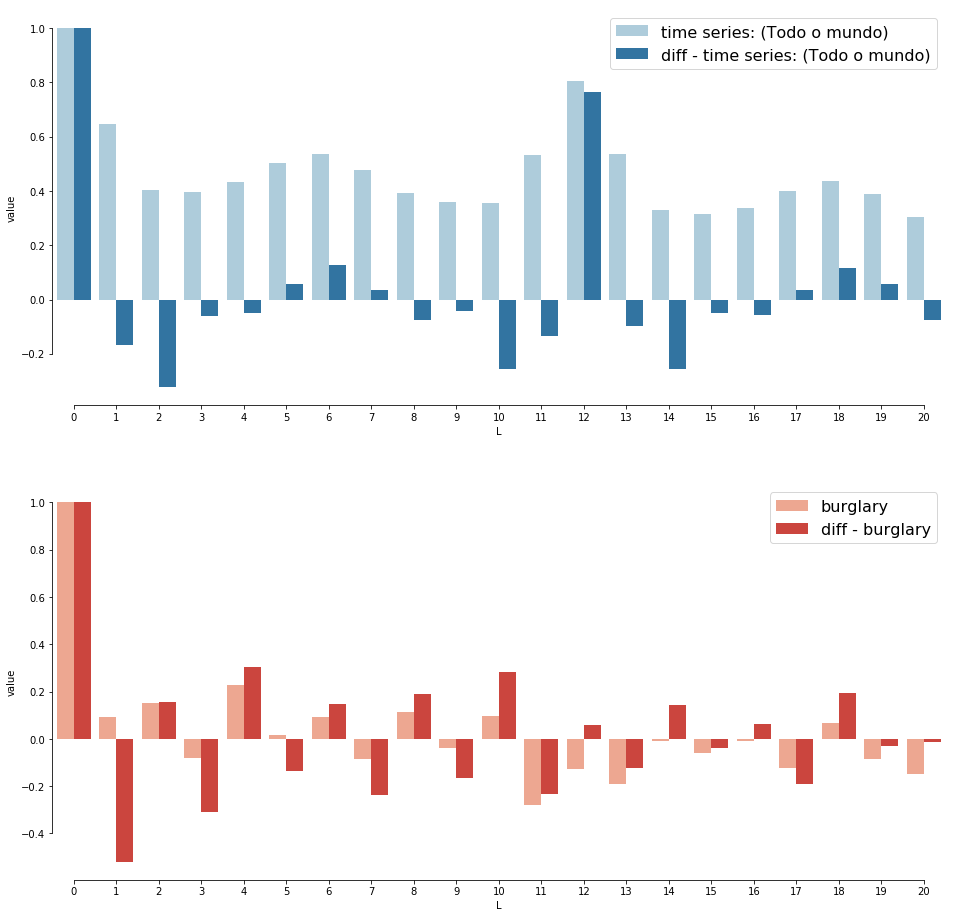

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(16,16))

ts_ts = {'time series: (Todo o mundo)': trends['time series: (Todo o mundo)'], 
      'diff - time series: (Todo o mundo)':np.diff(trends['time series: (Todo o mundo)'])}
cr_ts = {
      'burglary': burglary_ts,
      'diff - burglary':np.diff(burglary_ts)}

A = pd.DataFrame()
for a in ts_ts:
    autoc = acf(ts_ts[a], nlags=20)
    autoc = pd.DataFrame(autoc, columns=['value'], index=[a]*len(autoc)).reset_index()
    autoc['L'] = range(21)
    A = A.append(autoc)
sns.barplot(data=A, x='L', y='value', hue='index',ax=ax[0], palette='Paired')
ax[0].legend(fontsize=16, loc=0)

A = pd.DataFrame()
for a in cr_ts:
    autoc = acf(cr_ts[a], nlags=20)
    autoc = pd.DataFrame(autoc, columns=['value'], index=[a]*len(autoc)).reset_index()
    autoc['L'] = range(21)
    A = A.append(autoc)
sns.barplot(data=A, x='L', y='value', hue='index',ax=ax[1], palette='Reds')
ax[1].legend(fontsize=16, loc=0)
sns.despine(trim=True)

## 3. Extração de características/descritores

***

(entenda descritores e características como sinônimos, em tradução à *features*)


### 3.1. Interpolação, regressão e predição

Apesar de apresentarem técnicas muito similares, essas três formas de se fazer estimativa em séries temporais se destinam a casos de usos bastante diferentes. Ambas as três se constituem na tarefa de se estimar um valor contínuo dado, no mínimo, duas amostras e/ou seus descritores.

* A **interpolação** se constitui no processo de calcular um valor de ajuste entre amostras no $\mathbb{R}^n$, buscando um ajuste perfeito, sem se preocupar com a variância presente nas amostras. Ela possui aplicações no contexto de séries temporais principalmente quando se quer fazer um *oversampling*. 
* Similarmente, a **regressão** se preocupa em estimar valores de maneira a generalizar a variância das amostras, e da mesma forma busca estimar valores presentes em um intervalo delimitado pelas amostras.
* A **predição** não é bem uma categoria comparável às outras duas. Aqui introduzo ela na discussão para se ter uma ideia de por onde a predição se ergue, que é exatamente na regressão. Mas apesar de os métodos de predição reproduzirem o aspecto da regressão de generalização da variância, quando se fala em predição a motivação se conduz sob o domínio temporal, em que se busca estimar valores futuros baseados em observações passadas. 

De toda forma, para estruturar modelos de regressão aplicados a predição, foco desse tutorial, a ideia principal é extrair descritores que possam ajudar a explicar a variância da variável a ser predita, sem utilizar informações em que o atributo temporal coincida com o tempo em que se quer prever. 


### 3.2. Descritores autorregressivos

Quando se pensa em predição, a grande maioria dos modelos podem ser chamados de "autorregressivos", isso por que realizam regressão em seus próprios componentes, no caso, observações passadas. Para alimentar modelos autorregressivos, a ideia em se utilizar observações passadas requer a disponibilização desses que são chamados componentes autorregressivos. A ideia de utilizar a expressão descritores autorregressivos vem no sentido de caracterizar uma amostras com suas próprias observações/descrições anteriores/autorregressivas, ou também chamados de **lags**.

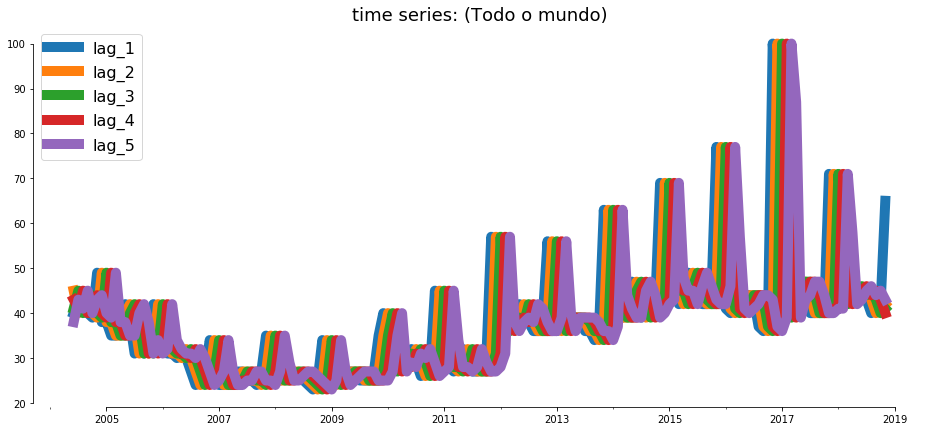

In [12]:
def lags(y, L, label='lag'):
    X = np.matrix(np.empty(shape=(len(y)-L,L)))
    for l in range(0,L):
            X[:,l] = y[L-1-l:len(y)-l-1].values.reshape(-1,1)
    return pd.DataFrame(X, columns=["{}_{}".format(label,x+1) for x in range(L)], index=y.index.values[L:])

fig, ax = plt.subplots(figsize=(16,7))
X = lags(trends['time series: (Todo o mundo)'], 5)
X.plot(ax=ax, linewidth=10)
ax.set_title('time series: (Todo o mundo)', fontsize=18)
ax.legend(fontsize=16, loc=2)
sns.despine(trim=True)

Um exemplo de uma modelagem linear de $Y$ através de uma estimativa autorregressiva $AR(Y,p)$:

<h2>$ \hat{Y}(t) = \sum^{p \in L} \alpha_p* Y(t-p)$ </h2>

### 3.3. Descritores exógenos

Para complementar a predição, modelos multivariados também são bem vindos. E para descrever as demais variáveis, aqui referidas como exógenas (em relação à variável a ser predita). A extração de descritores exógenos depende de cada aplicação, e a recomendação é utilizá-los quando seus comportamentos podem ajudar a explicar a variância da série original. 

São exemplos de descritores exógenos em relação às séries temporais de crimes as notícias sobre segurança pública, dados extraídos do Twitter etc.

Um modelo que considera descritores exógenos $X$ e autorregressivos pode ser expressado de forma linear através de:

<h2>$ \hat{Y}(t) = \sum^{p \in L} [\alpha_pY(t-p) + \beta_pX(t-p)]$</h2>


### 3.4. Seleção de características

O processo de subamostrar atributos em modelos é chamado de seleção de características, e tem o intuito de simplificar os modelos, reduzir a variância da predição e evitar a chamada "maldição da dimensionalidade". Existem diversas técnicas para realizar a seleção, recomendo a leitura do artigo *"A Benchmark of Prevalent Feature Selection Algorithms on a Diverse Set of Classification Problems"*, de Kniberg e Nokto (2018), para devido entendimento e escolha da técnica mais apropriada.

## 4. Análise preditiva

A modelagem tratada nesse notebook será focada em aprendizado de máquina, que são costumeiramente modelos não-lineares, no caso da predição supervisionados, para ajustar uma função à uma matriz de descritores no sentido de minimizar o erro entre a estimativa e os valores reais.



### 4.1. Aprendizado de máquina

![ML](images/ml__.png)

Considere a matriz de descritores $X$ composta somente de componentes autorregressivos, e o vetor $y$ a ser predito. Vamos utilizar um algoritmo de aprendizado de máquina (ML) para modelar a entrada na saída minimizando o erro de estimativa. 

In [33]:
y = trends['time series: (Todo o mundo)']
X = lags(y, 12)
y = y.loc[X.index]
print('X = \n',X.head())
print()
print('y = \n',y.head())

X = 
             lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
2005-01-01   38.0   38.0   49.0   39.0   40.0   44.0   43.0   40.0   45.0   
2005-02-01   35.0   38.0   38.0   49.0   39.0   40.0   44.0   43.0   40.0   
2005-03-01   35.0   35.0   38.0   38.0   49.0   39.0   40.0   44.0   43.0   
2005-04-01   40.0   35.0   35.0   38.0   38.0   49.0   39.0   40.0   44.0   
2005-05-01   42.0   40.0   35.0   35.0   38.0   38.0   49.0   39.0   40.0   

            lag_10  lag_11  lag_12  
2005-01-01    41.0    43.0    38.0  
2005-02-01    45.0    41.0    43.0  
2005-03-01    40.0    45.0    41.0  
2005-04-01    43.0    40.0    45.0  
2005-05-01    44.0    43.0    40.0  

y = 
 2005-01-01    35
2005-02-01    35
2005-03-01    40
2005-04-01    42
2005-05-01    38
Name: time series: (Todo o mundo), dtype: int64


### 4.2.  Performance dos modelos

Para avaliar a performance, deixaremos uma amostra dos últimos 30% dos valores a serem utilizados como validação, medindo o erro médio quadrático ($MSE$). Esse método de deixar 

<h2>$MSE(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$</h2>

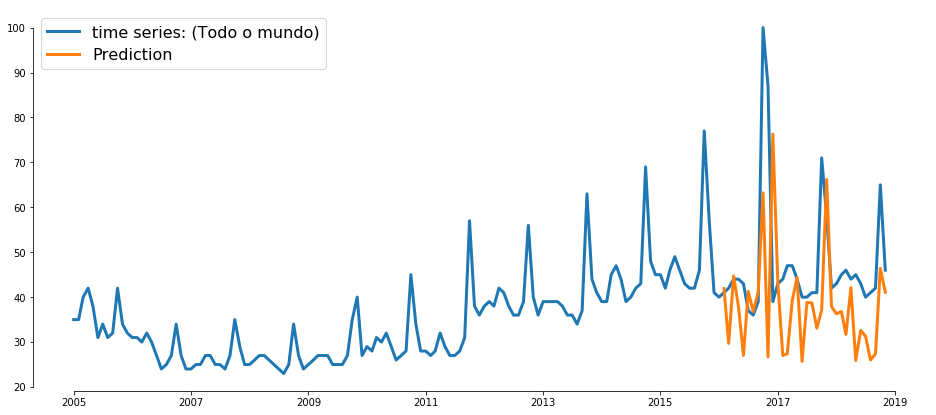

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
ml = RandomForestRegressor()
ml.fit(X_train, y_train)

y_hat = ml.predict(X_test)

#plot
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(y, linewidth=3, label='time series: (Todo o mundo)')
ax.plot(pd.Series(y_hat,index=y.index[-int(len(y)*0.2)-1:]), linewidth=3, label='Prediction')
plt.legend(loc=2, fontsize=16)
sns.despine(trim=True)

In [35]:
mean_squared_error(y_test, y_hat)

45.404999999999994

Como se vê, o modelo autorregressivo puro não produz descritores suficientes para que o Random Forest consiga predizer, até por que existe um viés nos dados de teste que não está presente nos dados de treino e, portanto, esse comportamento não será muito bem mapeado com a estratégia utilizada. Para amenizar essa questão, pode se empregar técnicas de Cross-Validação (**CV**), de modo que se avalie o algoritmo em diferentes fatias, ou *folds*, de dados e empregue uma metodologia de média dos erros.


### 4.3.  Engenharia de descritores

Uma das estratégias alternativas para lidar com o fracasso no aprendizado é utilizar outros descritores, seja a partir dos próprios componentes autorregressivos, ou através de descritores exógenos, como discutido anteriormente. Nesse caso, vamos tentar incluir descritores de tendência e sazonalidade de modo que o modelo também utilize essas informações, em formas de seus lags, para prever.


In [36]:
d = seasonal_decompose(trends['time series: (Todo o mundo)'], model='multiplicative', two_sided=False)

T = lags(d.trend, 12, label='trend_lag').dropna()
S = lags(d.seasonal, 12, label='seas_lag').loc[T.index]
X = T.join(S).join(X)
X.head()

,trend_lag_1,trend_lag_2,trend_lag_3,trend_lag_4,trend_lag_5,trend_lag_6,trend_lag_7,trend_lag_8,trend_lag_9,trend_lag_10,...,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
2006-01-01,35.750000,36.166667,36.625000,37.208333,37.875000,38.666667,39.583333,40.166667,40.375000,40.541667,...,42.0,32.0,31.0,34.0,31.0,38.0,42.0,40.0,35.0,35.0
2006-02-01,35.333333,35.750000,36.166667,36.625000,37.208333,37.875000,38.666667,39.583333,40.166667,40.375000,...,34.0,42.0,32.0,31.0,34.0,31.0,38.0,42.0,40.0,35.0
2006-03-01,35.000000,35.333333,35.750000,36.166667,36.625000,37.208333,37.875000,38.666667,39.583333,40.166667,...,32.0,34.0,42.0,32.0,31.0,34.0,31.0,38.0,42.0,40.0
2006-04-01,34.416667,35.000000,35.333333,35.750000,36.166667,36.625000,37.208333,37.875000,38.666667,39.583333,...,31.0,32.0,34.0,42.0,32.0,31.0,34.0,31.0,38.0,42.0
2006-05-01,33.583333,34.416667,35.000000,35.333333,35.750000,36.166667,36.625000,37.208333,37.875000,38.666667,...,31.0,31.0,32.0,34.0,42.0,32.0,31.0,34.0,31.0,38.0


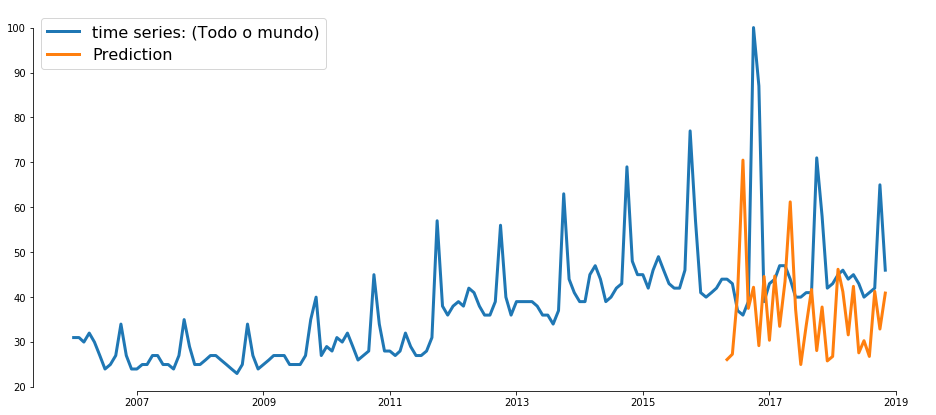

In [46]:
y = trends['time series: (Todo o mundo)'].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
ml = RandomForestRegressor()
ml.fit(X_train, y_train)

y_hat = ml.predict(X_test)

#plot
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(y, linewidth=3, label='time series: (Todo o mundo)')
ax.plot(pd.Series(y_hat,index=y.index[-int(len(y)*0.2):]), linewidth=3, label='Prediction')
plt.legend(loc=2, fontsize=16)
sns.despine(trim=True)

In [47]:
mean_squared_error(y_test, y_hat)

20.63193548387097

Ou ainda, podemos tentar prever a série diferenciada.

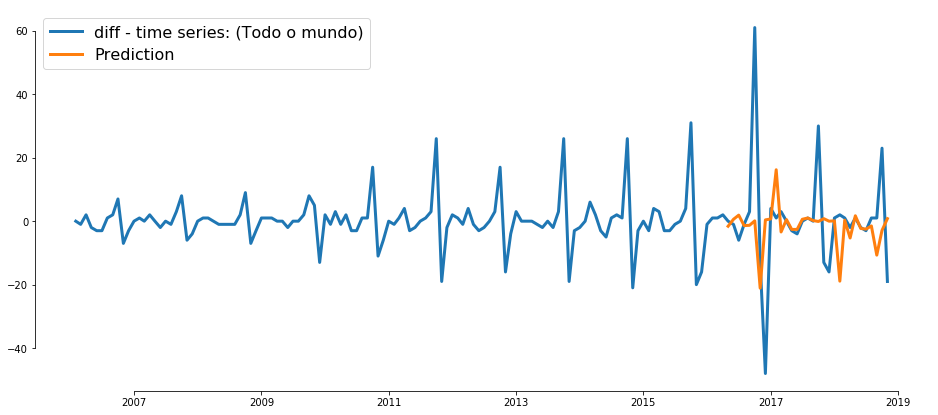

In [48]:
y = trends['time series: (Todo o mundo)'].loc[X.index]
y = pd.Series(np.diff(y), index=y.index[1:])
X_train, X_test, y_train, y_test = train_test_split(X.iloc[1:], y, test_size=0.20)
ml = RandomForestRegressor()
ml.fit(X_train, y_train)
y_hat = ml.predict(X_test)

#plot
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(y, linewidth=3, label='diff - time series: (Todo o mundo)')
ax.plot(pd.Series(y_hat,index=y.index[-int(len(y)*0.2)-1:]), linewidth=3, label='Prediction')
plt.legend(loc=2, fontsize=16)
sns.despine(trim=True)

## 5. Conclusão


- Análise de séries temporais é um assunto antigo, abordado principalmente pela literatura estatística;
- Podemos, e até devemos, fazer uma análise exploratória nas nossas séries, para analisar pontos como devemos tratar *missing data*, o quão a série é estacionária, quanto podemos utilizar de seus componentes autorregressivos em termos de seus lags;
- A extração de componentes autorregressivos é importante para alimentar modelos de predição em séries temporais;
- Decompor nossas séries temporais em tendência e sazonalidade pode nos oferecer um conjunto de descritores mais diverso;
- Algoritmos de aprendizado de máquina supervisionada, principalmente de regressão, podem servir como modelos de predição e
- O processo de engenharia de descritores exige criatividade para que sejam desenhadas descritores apropriados para mapear as características da série a ser prevista.


Duvidas, sugestões? Entre em contato por e-mail!